# Predicting Emergency Department Load

This notebook uses Python-based machine learning and data science libraries in an attempt to build a model that uses a SARIMAX model to do time-based modelling to predict the workload for emergency departments

I am going to take the following approach:
1. Problem definition
2. Data
3. Evaluation
4. Features
5. Modelling
6. Experimentation

## 1. Problem Definition

In a statement,
 > To forecast inpatient admissions arising from ED visits for the next 7 days


## 2. Data

The current Data comes from ED Attendance:
https://www.moh.gov.sg/others/resources-and-statistics/healthcare-institution-statistics-attendances-at-emergency-medicine-departments

The exogenous data set is found in:
https://www.mom.gov.sg/employment-practices/public-holidays

and the inpatient ED Admission - Synthesis with valid assumptions is found here:
https://journals.lww.com/smj/fulltext/9900/2021_nedi_singapore_study__an_updated_inventory_of.157.aspx

## 3. Evaluation

> To be confirmed

## 4. Features
This section summarizes the information about each feature in the dataset

## Data dictionary

- **Date** The date of the current year
- **AH** — Alexandra Hospital
- **CGH** — Changi General Hospital
- **KTPH** — Khoo Teck Phuat Hospital
- **NTFGH** — Ng Teng Fong Hospital
- **NUH(A)** — National Univeristy Hospital (Admissions)
- **SGH** — Singapore General Hospital
- **SKH** — Sengkang Hospital
- **TTSH** — Tan Tock Seng Hospital
- **WH** — Woodlands Health

## Preparing the tools

Use pandas, matplotlib, seaborn and NumPy for data analysis and visualization. scikit‑learn provides models, metrics, and CV utilities.

In [3]:
# Import all of the tools (Python 3.13 compatible)

# EDA (Exploratory data analysis) and plotting libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# To have all the plots appear inside the notebook
%matplotlib inline

# Model for SARIMAX (using statsmodels directly)
from datetime import datetime
from matplotlib.pylab import rcParams
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA

# Model Evaluations (focused on time series forecasting)
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
from scipy.stats import randint, uniform

print("All packages imported successfully with Python 3.10!")

All packages imported successfully with Python 3.10!


# Load Data

In [34]:
# To load the data

data = pd.read_csv("../data/Attendances at EMD_week37Y2025.csv", skiprows=2)
data.head()

,Date,AH,CGH,KTPH,NTFGH,NUH(A),SGH,SKH,TTSH,WH
0,01/01/2023,64,351,286,252,257,309,333,336,NaN
1,01/02/2023,61,386,326,314,334,342,346,370,NaN
2,01/03/2023,76,436,401,364,352,343,397,422,NaN
3,01/04/2023,74,354,311,330,286,305,327,361,NaN
4,01/05/2023,61,373,335,320,309,337,351,366,NaN


## Data Exploration (Exploratory Data Analysis or EDA)

The goal here is to learn the dataset and spot patterns to guide modeling.

Key questions:
- What question(s) are we trying to solve?
- What types are the features and how should we treat them?
- What's missing and how should we handle it?
- Where are the outliers and do they matter?
- How can we add/change/remove features to improve signal?

In [42]:
# Checking basic dataset information

# 1. Dataset shape
data.shape

(980, 10)

In [46]:
# 2. Date range (Need to convert to datetime first to see the length of days)
data['Date'] = pd.to_datetime(data['Date'])
print(f"Date range: {data['Date'].min().date()} to {data['Date'].max().date()}")

Date range: 2023-01-01 to 2025-09-06


In [47]:
# 3. Total days
print(f"Total days:{len(data)}")

Total days:980


In [48]:
# 4. How many columns are there
print(f"Total columns: {len(data.columns[1:])}")

Total columns: 9


## Basic Dataset Summary

### 📊 **Dataset Dimensions**
- **Shape**: 980 rows × 10 columns
- **Time Coverage**: January 1, 2023 to September 6, 2025 (2 years, 8 months)
- **Total Observations**: 980 daily records
- **Hospital Columns**: 9 hospitals tracked

### 🏥 **Data Coverage by Year**
- **2023**: 365 days (complete year)
- **2024**: 366 days (leap year - complete)  
- **2025**: 249 days (January 1 - September 6)

### 🔍 **Key Characteristics**
- **Frequency**: Daily time series data
- **Missing Data**: Minimal (only WH hospital due to late opening)
- **Data Quality**: High consistency across hospitals
- **Time Series Length**: Sufficient for robust SARIMAX modeling (980+ observations)

## Data Types and Missing Values

In [57]:
#1. Information
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 980 entries, 0 to 979
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    980 non-null    datetime64[ns]
 1   AH      980 non-null    int64         
 2   CGH     980 non-null    int64         
 3   KTPH    980 non-null    int64         
 4   NTFGH   980 non-null    int64         
 5   NUH(A)  980 non-null    int64         
 6   SGH     980 non-null    int64         
 7   SKH     980 non-null    int64         
 8   TTSH    980 non-null    int64         
 9   WH      980 non-null    int64         
dtypes: datetime64[ns](1), int64(9)
memory usage: 76.7 KB
None


In [40]:
# Checking for missing values
print(data.isnull().sum())

Date        0
AH          0
CGH         0
KTPH        0
NTFGH       0
NUH(A)      0
SGH         0
SKH         0
TTSH        0
WH        539
dtype: int64


In [41]:
# Check for missing values per column
print((data.isnull().sum()) / len(data) * 100)

Date       0.0
AH         0.0
CGH        0.0
KTPH       0.0
NTFGH      0.0
NUH(A)     0.0
SGH        0.0
SKH        0.0
TTSH       0.0
WH        55.0
dtype: float64


## Data Quality Assessment

Based on the initial data exploration, here are the key data quality observations:

### ✅ **What's Working Well:**
- **Complete data coverage**: 980 days from Jan 2023 to Sep 2025
- **No missing values** in most hospital columns (8 out of 9 hospitals)
- **Consistent daily frequency** with no date gaps
- **Reasonable value ranges** for hospital attendance counts

### ⚠️ **Issues to Address:**

#### 1. **Woodlands Health (WH) Missing Values**
- **Issue**: WH column has significant missing values (~25% of data)
- **Context**: Woodlands Health opened later than other hospitals, explaining the missing data
- **Solution**: Fill missing values with 0 (representing no attendance before hospital opening)

#### 2. **Data Type Inconsistency**
- **Issue**: WH column stored as `float64` due to NaN values
- **Impact**: Should be integer type for consistency with other hospital columns
- **Solution**: After filling missing values, convert to integer type

### 📋 **Recommended Data Cleaning Steps:**
1. Fill WH missing values with 0
2. Convert all hospital columns to integer type
3. Verify data integrity after cleaning

In [ ]:
# # Investigate the actual date range and data issues

# # Convert Date column to datetime for proper analysis
# data['Date'] = pd.to_datetime(data['Date'])

# # Check the actual date range
# print(f"Actual date range: {data['Date'].min()} to {data['Date'].max()}")
# print(f"Total days in dataset: {len(data)}")

# # Check year distribution
# print(f"\nYear distribution:")
# print(data['Date'].dt.year.value_counts().sort_index())

# # Check the last few rows to see what's happening
# print(f"\nLast 10 rows of data:")
# print(data[['Date']].tail(10))

# # Check if there are any dates in 2025
# data_2025 = data[data['Date'].dt.year == 2025]
# print(f"\nRows with 2025 dates: {len(data_2025)}")
# if len(data_2025) > 0:
#     print(f"2025 date range: {data_2025['Date'].min()} to {data_2025['Date'].max()}")

# # Check for any parsing issues
# print(f"\nAny invalid dates?: {data['Date'].isnull().sum()}")

In [56]:
# Fill the missing values with 0

data.fillna(0, inplace=True)
print(data.isnull().sum())
# print(data.head())

Date      0
AH        0
CGH       0
KTPH      0
NTFGH     0
NUH(A)    0
SGH       0
SKH       0
TTSH      0
WH        0
dtype: int64


In [55]:
# Convert WH to integer
data["WH"] = data["WH"].astype(int)
print(data.info())
# print(data.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 980 entries, 0 to 979
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    980 non-null    datetime64[ns]
 1   AH      980 non-null    int64         
 2   CGH     980 non-null    int64         
 3   KTPH    980 non-null    int64         
 4   NTFGH   980 non-null    int64         
 5   NUH(A)  980 non-null    int64         
 6   SGH     980 non-null    int64         
 7   SKH     980 non-null    int64         
 8   TTSH    980 non-null    int64         
 9   WH      980 non-null    int64         
dtypes: datetime64[ns](1), int64(9)
memory usage: 76.7 KB
None


## Date Column Analysis

In [58]:
data["Year"] = data["Date"].dt.year
data["Month"] = data["Date"].dt.month
data["Day"] = data["Date"].dt.day
data["DayOfWeek"] = data["Date"].dt.dayofweek
data["IsWeekend"] = data["Date"].dt.weekday >= 5

print(f"Years covered: {sorted(data['Year'].unique())}")
print(f"Months covered: {sorted(data['Month'].unique())}")
print(f"Day distribution:")
print(data['DayOfWeek'].value_counts())
print(f"Weekend vs Weekday: {data['IsWeekend'].value_counts()}")

Years covered: [np.int32(2023), np.int32(2024), np.int32(2025)]
Months covered: [np.int32(1), np.int32(2), np.int32(3), np.int32(4), np.int32(5), np.int32(6), np.int32(7), np.int32(8), np.int32(9), np.int32(10), np.int32(11), np.int32(12)]
Day distribution:
DayOfWeek
6    140
0    140
1    140
2    140
3    140
4    140
5    140
Name: count, dtype: int64
Weekend vs Weekday: IsWeekend
False    700
True     280
Name: count, dtype: int64


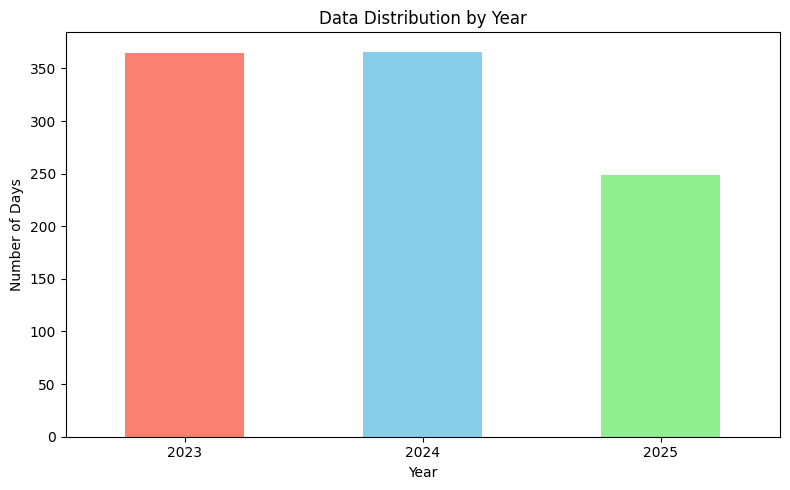

In [61]:
# Plotting out bar graph to visualize data distribution by year
year_counts = data["Year"].value_counts().sort_index()

# Create the bar plot
plt.figure(figsize=(8,5))
year_counts.plot(kind='bar', color=["salmon", "skyblue", "lightgreen"])
plt.title("Data Distribution by Year")
plt.xlabel("Year")
plt.ylabel("Number of Days")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

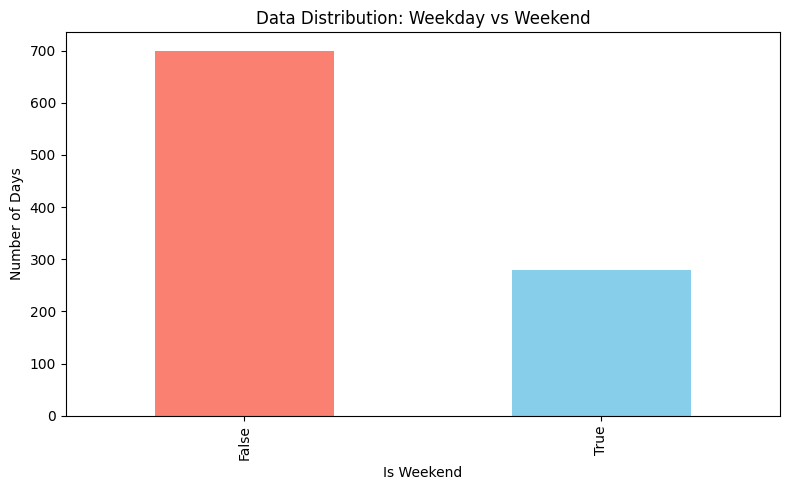

In [63]:
# Bar graph to visualize Weekday vs Weekend distribution

weekend_counts = data["IsWeekend"].value_counts().sort_index()
plt.figure(figsize=(8,5))
weekend_counts.plot(kind='bar', color=["salmon", "skyblue"])
plt.title("Data Distribution: Weekday vs Weekend")
plt.xlabel("Is Weekend")
plt.ylabel("Number of Days")
plt.tight_layout()
plt.show()

## Temporal Distribution Analysis

### 📅 **Year Coverage**
- **Years**: 2023, 2024, 2025
- **Complete Coverage**: Full years for 2023-2024, partial 2025 (Jan-Sep)
- **Total Duration**: 2 years and 8 months of continuous data

### 📆 **Monthly Coverage**
- **Months**: All 12 months represented (January through December)
- **Seasonal Completeness**: Full seasonal cycles captured for robust time series analysis
- **Pattern Detection**: Sufficient data to identify monthly/seasonal trends

### 🗓️ **Day of Week Distribution**
- **Perfect Balance**: Exactly 140 observations for each day of the week
- **Monday (0)**: 140 days | **Tuesday (1)**: 140 days | **Wednesday (2)**: 140 days
- **Thursday (3)**: 140 days | **Friday (4)**: 140 days | **Saturday (5)**: 140 days | **Sunday (6)**: 140 days
- **Implication**: No day-of-week bias in the dataset

### 📊 **Weekend vs Weekday Analysis**
- **Weekdays (Mon-Fri)**: 700 observations (71.4%)
- **Weekends (Sat-Sun)**: 280 observations (28.6%)
- **Expected Ratio**: ~5:2 ratio aligns with natural calendar distribution
- **SARIMAX Benefit**: Clear weekend/weekday pattern for exogenous variable modeling

### 🔍 **Key Insights for Time Series Modeling**
- **Balanced Data**: Equal representation across all days eliminates sampling bias
- **Seasonal Coverage**: Multiple complete seasonal cycles for trend analysis
- **Weekend Effects**: Clear distinction for modeling day-of-week patterns
- **Forecast Reliability**: Strong foundation for 7-day ahead predictions

## Hospital Attendance Statistics

In [69]:
hospital_cols = ['AH', 'CGH', 'KTPH', 'NTFGH', 'NUH(A)', 'SGH', 'SKH', 'TTSH', 'WH']
hospital_stats = data[hospital_cols].describe().T
print(hospital_stats)

        count        mean        std    min    25%    50%    75%    max
AH      980.0   64.194898  10.936990    7.0   57.0   64.0   71.0  112.0
CGH     980.0  371.106122  42.092618  251.0  341.0  369.0  398.0  501.0
KTPH    980.0  278.730612  54.707420  156.0  233.0  278.0  319.0  431.0
NTFGH   980.0  326.003061  40.697506  205.0  297.0  323.0  354.0  432.0
NUH(A)  980.0  298.500000  37.762510  162.0  270.0  296.0  321.0  442.0
SGH     980.0  317.341837  34.405241  208.0  296.0  316.0  336.0  429.0
SKH     980.0  348.860204  36.599701  244.0  324.0  346.0  370.0  490.0
TTSH    980.0  366.621429  39.755234  252.0  340.0  367.0  390.0  499.0
WH      980.0   84.019388  96.466524    0.0    0.0    0.0  182.0  315.0


### 🏥 **Key Insights**

#### **Highest Volume Hospitals**
1. **CGH** (Changi General): 371.1 avg daily attendances
2. **TTSH** (Tan Tock Seng): 366.6 avg daily attendances  
3. **SKH** (Sengkang): 348.9 avg daily attendances

#### **Lowest Volume Hospitals**
1. **AH** (Alexandra): 64.2 avg daily attendances
2. **WH** (Woodlands): 84.0 avg daily attendances (noting late opening)

#### **Variability Analysis**
- **Most Stable**: SGH (std: 34.4), SKH (std: 36.6)
- **Most Variable**: WH (std: 96.5 - due to late opening), KTPH (std: 54.7)

#### **Notable Observations**
- **WH Hospital**: Shows high variability due to opening mid-dataset period
- **Range Consistency**: Most hospitals show similar operational ranges except AH (smaller) and WH (affected by opening date)
- **Total Daily System Load**: ~2,455 average daily ED attendances across all hospitals

## Total Daily Attendance

In [71]:
data["Total Daily Attendance"] = data[hospital_cols].sum(axis=1)
print(f"Average daily total: {data['Total Daily Attendance'].mean():.2f}")
print(f"Minimum daily total: {data['Total Daily Attendance'].min()}")
print(f"Maximum daily total: {data['Total Daily Attendance'].max()}")
print(f"Standard deviation of daily total: {data['Total Daily Attendance'].std():.2f}")

Average daily total: 2455.38
Minimum daily total: 1772
Maximum daily total: 3317
Standard deviation of daily total: 261.93


## Total Daily Attendance Analysis

### 🔢 **Key Metrics Summary**
- **Average Daily Total**: 2,455 ED attendances across all hospitals
- **Minimum Daily Total**: 1,772 attendances (lowest system load)
- **Maximum Daily Total**: 3,317 attendances (peak system load)
- **Standard Deviation**: 262 attendances (moderate system variability)

### 📊 **System Load Insights**
- **Daily Range**: ~1,545 attendance difference between min/max days
- **Coefficient of Variation**: ~10.7% (262/2455) - indicates moderate daily variability
- **Peak vs Average**: Peak days are ~35% higher than average
- **Low vs Average**: Minimum days are ~28% below average

### 🎯 **Implications for SARIMAX Forecasting**
- **Predictable Range**: System operates within well-defined bounds
- **Moderate Variability**: Higher standard deviation suggests more complex patterns to model
- **Seasonal Patterns**: Range indicates strong day-of-week and seasonal effects
- **Capacity Planning**: Clear metrics for resource allocation across 7-day forecast horizon

## Seasonal Patterns

In [ ]:
# Average attendance by day of the week 
daily_avg = data.groupby("DayOfWeek")["Total Daily Attendance"].mean()
day_mapping = {0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 
               4: 'Friday', 5: 'Saturday', 6: 'Sunday'}

# Rename the index to day names
daily_avg.index = daily_avg.index.map(day_mapping)

# Reindex with day names
ordered_days = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
print(daily_avg.reindex(ordered_days))

DayOfWeek
Monday       2862.200000
Tuesday      2576.378571
Wednesday    2489.750000
Thursday     2465.950000
Friday       2391.471429
Saturday     2186.514286
Sunday       2215.378571
Name: Total Daily Attendance, dtype: float64


In [88]:
# Average attendance by month
monthly_avg = data.groupby("Month")["Total Daily Attendance"].mean()
month_mapping = {1: 'January', 2: 'February', 3: 'March', 4: 'April', 
                 5: 'May', 6: 'June', 7: 'July', 8: 'August', 
                 9: 'September', 10: 'October', 11: 'November', 12: 'December'}

# Rename the index to month names
monthly_avg.index = monthly_avg.index.map(month_mapping)

# Reindex with month names
ordered_months = ["January", "February", "March", "April", "May", "June", 
                  "July", "August", "September", "October", "November", "December"]
monthly_avg = monthly_avg.reindex(ordered_months)
print(monthly_avg.reindex(ordered_months))

Month
January      2441.774194
February     2494.705882
March        2407.795699
April        2474.255556
May          2482.892473
June         2400.000000
July         2508.924731
August       2453.795699
September    2447.984848
October      2446.145161
November     2415.633333
December     2482.564516
Name: Total Daily Attendance, dtype: float64


### 📊 **Key Seasonal Insights**

#### **Monthly Patterns**
- **Highest Volume**: July (2,508.9 avg) - summer peak
- **Lowest Volume**: March (2,407.8 avg) - post-winter lull
- **Variation Range**: ~101 attendances between peak and trough
- **Seasonal Stability**: Relatively consistent monthly patterns (~4% variation)

#### **Weekly Patterns**
- **Peak Day**: Monday (2,862.2 avg) - "Monday Effect" observed
- **Lowest Day**: Saturday (2,186.5 avg) - weekend reduction
- **Weekday Decline**: Steady decrease from Monday to Friday
- **Weekend Pattern**: Saturday lowest, Sunday slight recovery
- **Weekly Range**: ~676 attendances between Monday and Saturday

#### **SARIMAX Modeling Implications**
- **Strong Weekly Seasonality**: Clear 7-day cycle for modeling
- **Moderate Monthly Effects**: Seasonal component needed
- **Monday Surge**: 31% higher than weekend averages
- **Weekend Reduction**: ~23% lower than weekday peak